In [1]:
import sys
from data_helper import *

import keras
from keras.optimizers import *
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

from matplotlib import pyplot as plt
from numpy import array
from pandas import DataFrame
import pandas as pd
import numpy as np
import matplotlib
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0) # to make any matplotlib plot automatically a 20x10


import configparser
config = configparser.ConfigParser()
config.read('config/mylstmconfig.ini')

scaler = MinMaxScaler(feature_range=(0,1))
eco_tools_path = config['SETUP']['eco_tools_path']
sys.path.append(eco_tools_path)
from ecotools.pi_client import pi_client
pc = pi_client(root = 'readonly')

callbacks_list = [EarlyStopping(monitor='val_loss', patience=5, min_delta=0.001, verbose=2)]
#sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))


Using TensorFlow backend.


In [2]:
point_name = config['PI']['point_name']
start = config['PI']['start']
end = config['PI']['end']
interval = config['PI']['interval']
calculation = config['PI']['calculation']

In [3]:
point_list = [point_name, 'aiTIT4045']
df = pc.get_stream_by_point(point_list, start = start, end = end, calculation = calculation, interval= interval)
#df = pc.get_stream_by_point(point_list, end='*', calculation = calculation, interval= interval)
df = df.dropna(how='any')
df.head()

Grabbing WebIDs ...
WebID collection complete!
13:39:04: Sending API request... Chunk 1 of 1
13:39:07: Response recieved for 2 tags! (2.66)


/Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/pandas/core/arrays/datetimes.py:1027: FutureWarning: The errors argument is deprecated and will be removed in a future release. Use nonexistent='NaT' or nonexistent='raise' instead.
  "instead.", FutureWarning)


,GBSF_Electricity_Demand_kBtu,aiTIT4045
Timestamp,,
2016-01-01 00:00:00,2550.633333,40.409643
2016-01-01 01:00:00,2535.975618,40.079128
2016-01-01 02:00:00,2538.258333,40.090998
2016-01-01 03:00:00,2548.635795,40.114107
2016-01-01 04:00:00,2556.464644,39.902123


In [4]:
df, df1 = clean_train_data(df, eval_expression=["df.loc[df['GBSF_Electricity_Demand_kBtu'] > 2400]","df.loc[df.index.year >= 2019]"])
#print(df.shape)
#print(df1.shape)

Evaluating: df.loc[df['GBSF_Electricity_Demand_kBtu'] > 2400]
Evaluating: df.loc[df.index.year >= 2019]


In [5]:
df.shape

(30973, 2)

In [6]:
df1.shape

(4870, 2)

In [7]:
df = create_standard_multivariable_df(df)
df1 = create_standard_multivariable_df(df1)

Generated: 49 columns
Generated: 49 columns


In [8]:
def add_rolling_mean(df, point_loc, rolling):
    return df.iloc[ : , point_loc].rolling(rolling).mean()

In [9]:
kwargs = {'point_loc': 0, 'rolling': '12h'}
df = add_variable_to_df(df, add_rolling_mean, col_name="Rolling12_mean", kwargs = kwargs)
df1 = add_variable_to_df(df1, add_rolling_mean, col_name="Rolling12_mean", kwargs = kwargs)

In [10]:
print(f"df: {df.shape}")
print(f"df1: {df1.shape}")

df: (30972, 52)
df1: (4869, 52)


In [12]:
np.setdiff1d(df.columns,df1.columns)


array([], dtype=object)

In [13]:
def scale_keras(X, y):
    # normalize the dataset
    scaler_x = MinMaxScaler(feature_range=(0, 1))
    scaler_y = MinMaxScaler((0, 1))
    X = scaler_x.fit_transform(X)
    y = scaler_y.fit_transform(np.array(y).reshape((-1,1)))
    # split into train and test sets
    train_size = int(len(X) * 0.7)
    test_size = len(X) - train_size
    X_train, X_test = X[0:train_size], X[test_size:len(X)]
    y_train, y_test = y[0:train_size], y[test_size:len(y)]
    return X_train, X_test, y_train, y_test, scaler_x, scaler_y

In [14]:
y = df[point_name]
X = df.drop(columns=point_name)
y1 = df1[point_name]
X1 = df1.drop(columns=point_name)

In [15]:
X_train, X_test, y_train, y_test, scaler_x, scaler_y = scale_keras(X, y)
X1_train, X1_test, y1_train, y1_test, scaler_x1, scaler_y1 = scale_keras(X1, y1)

In [16]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

X1_train = np.reshape(X1_train, (X1_train.shape[0], 1, X1_train.shape[1]))
X1_test = np.reshape(X1_test, (X1_test.shape[0], 1, X1_test.shape[1]))

In [17]:
train = DataFrame()
val = DataFrame()
np.random.seed(42)
epochs = 400
neurons = 100
for i in range(1):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences = True))
    model.add(LSTM(neurons))
    model.add(Dense(1))
    model.compile(optimizer = Adam(lr = 0.001), loss = 'mean_squared_error')
    #X,y = get_train()
    #valX, valY = get_val()
    # fit model
    history = model.fit(X_train, y_train, epochs = epochs, validation_split = 0.3, shuffle = False)
    # story history
    train[str(i)] = history.history['loss']
    val[str(i)] = history.history['val_loss']

W0723 13:39:47.428791 4334949824 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 13:39:47.452415 4334949824 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 13:39:47.456421 4334949824 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 13:39:47.782166 4334949824 deprecation_wrapper.py:119] From /Users/josuealemansanchez/miniconda3/envs/work/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimiz

Train on 15175 samples, validate on 6505 samples
Epoch 1/400
15175/15175 [==============================] - 3s 216us/step - loss: 0.0284 - val_loss: 0.0038
Epoch 2/400
15175/15175 [==============================] - 2s 137us/step - loss: 0.0014 - val_loss: 0.0028
Epoch 3/400
15175/15175 [==============================] - 2s 137us/step - loss: 9.1973e-04 - val_loss: 0.0022
Epoch 4/400
15175/15175 [==============================] - 2s 137us/step - loss: 8.4763e-04 - val_loss: 0.0021
Epoch 5/400
15175/15175 [==============================] - 2s 137us/step - loss: 8.1954e-04 - val_loss: 0.0021
Epoch 6/400
15175/15175 [==============================] - 2s 138us/step - loss: 8.4924e-04 - val_loss: 0.0023
Epoch 7/400
15175/15175 [==============================] - 2s 140us/step - loss: 9.2652e-04 - val_loss: 0.0025
Epoch 8/400
15175/15175 [==============================] - 2s 151us/step - loss: 0.0010 - val_loss: 0.0026
Epoch 9/400
15175/15175 [==============================] - 2s 156us/step - 

15175/15175 [==============================] - 2s 144us/step - loss: 1.4241e-04 - val_loss: 5.5822e-04
Epoch 73/400
15175/15175 [==============================] - 2s 143us/step - loss: 1.3869e-04 - val_loss: 5.0648e-04
Epoch 74/400
15175/15175 [==============================] - 2s 143us/step - loss: 1.2835e-04 - val_loss: 5.3092e-04
Epoch 75/400
15175/15175 [==============================] - 2s 147us/step - loss: 1.2417e-04 - val_loss: 5.0729e-04
Epoch 76/400
15175/15175 [==============================] - 2s 144us/step - loss: 1.2236e-04 - val_loss: 5.0208e-04
Epoch 77/400
15175/15175 [==============================] - 2s 142us/step - loss: 1.2370e-04 - val_loss: 4.9521e-04
Epoch 78/400
15175/15175 [==============================] - 2s 141us/step - loss: 1.2296e-04 - val_loss: 5.1281e-04
Epoch 79/400
15175/15175 [==============================] - 2s 143us/step - loss: 1.2433e-04 - val_loss: 5.0928e-04
Epoch 80/400
15175/15175 [==============================] - 2s 145us/step - loss: 1.2

Epoch 143/400
15175/15175 [==============================] - 2s 142us/step - loss: 1.5218e-04 - val_loss: 9.6220e-04
Epoch 144/400
15175/15175 [==============================] - 2s 142us/step - loss: 1.4989e-04 - val_loss: 9.4886e-04
Epoch 145/400
15175/15175 [==============================] - 2s 146us/step - loss: 1.4662e-04 - val_loss: 9.5470e-04
Epoch 146/400
15175/15175 [==============================] - 2s 147us/step - loss: 1.4620e-04 - val_loss: 9.2419e-04
Epoch 147/400
15175/15175 [==============================] - 2s 143us/step - loss: 1.4582e-04 - val_loss: 8.9047e-04
Epoch 148/400
15175/15175 [==============================] - 2s 142us/step - loss: 1.4622e-04 - val_loss: 9.2642e-04
Epoch 149/400
15175/15175 [==============================] - 2s 141us/step - loss: 1.4638e-04 - val_loss: 8.7925e-04
Epoch 150/400
15175/15175 [==============================] - 2s 138us/step - loss: 1.4583e-04 - val_loss: 8.6925e-04
Epoch 151/400
15175/15175 [==============================] - 2s 

15175/15175 [==============================] - 2s 139us/step - loss: 1.4163e-04 - val_loss: 5.3380e-04
Epoch 214/400
15175/15175 [==============================] - 2s 141us/step - loss: 1.3851e-04 - val_loss: 5.4171e-04
Epoch 215/400
15175/15175 [==============================] - 2s 142us/step - loss: 1.3836e-04 - val_loss: 5.4050e-04
Epoch 216/400
15175/15175 [==============================] - 2s 141us/step - loss: 1.3552e-04 - val_loss: 5.4249e-04
Epoch 217/400
15175/15175 [==============================] - 2s 139us/step - loss: 1.3545e-04 - val_loss: 5.7170e-04
Epoch 218/400
15175/15175 [==============================] - 2s 137us/step - loss: 1.3230e-04 - val_loss: 5.6836e-04
Epoch 219/400
15175/15175 [==============================] - 2s 140us/step - loss: 1.3026e-04 - val_loss: 5.7315e-04
Epoch 220/400
15175/15175 [==============================] - 2s 141us/step - loss: 1.2775e-04 - val_loss: 5.6466e-04
Epoch 221/400
15175/15175 [==============================] - 2s 141us/step - l

15175/15175 [==============================] - 2s 141us/step - loss: 8.1149e-05 - val_loss: 4.2654e-04
Epoch 284/400
15175/15175 [==============================] - 2s 141us/step - loss: 8.0806e-05 - val_loss: 4.3865e-04
Epoch 285/400
15175/15175 [==============================] - 2s 138us/step - loss: 8.1513e-05 - val_loss: 4.3445e-04
Epoch 286/400
15175/15175 [==============================] - 2s 142us/step - loss: 8.1979e-05 - val_loss: 4.4236e-04
Epoch 287/400
15175/15175 [==============================] - 2s 146us/step - loss: 8.3003e-05 - val_loss: 4.4787e-04
Epoch 288/400
15175/15175 [==============================] - 2s 146us/step - loss: 8.3720e-05 - val_loss: 4.4746e-04
Epoch 289/400
15175/15175 [==============================] - 2s 146us/step - loss: 8.4821e-05 - val_loss: 4.6108e-04
Epoch 290/400
15175/15175 [==============================] - 2s 147us/step - loss: 8.6941e-05 - val_loss: 4.7270e-04
Epoch 291/400
15175/15175 [==============================] - 2s 145us/step - l

15175/15175 [==============================] - 2s 140us/step - loss: 6.4443e-05 - val_loss: 3.9092e-04
Epoch 354/400
15175/15175 [==============================] - 2s 137us/step - loss: 6.8135e-05 - val_loss: 4.0697e-04
Epoch 355/400
15175/15175 [==============================] - 2s 141us/step - loss: 6.7229e-05 - val_loss: 4.0636e-04
Epoch 356/400
15175/15175 [==============================] - 2s 143us/step - loss: 6.8318e-05 - val_loss: 3.9886e-04
Epoch 357/400
15175/15175 [==============================] - 2s 143us/step - loss: 6.7167e-05 - val_loss: 3.9327e-04
Epoch 358/400
15175/15175 [==============================] - 2s 142us/step - loss: 6.8347e-05 - val_loss: 4.1178e-04
Epoch 359/400
15175/15175 [==============================] - 2s 138us/step - loss: 6.4772e-05 - val_loss: 3.9447e-04
Epoch 360/400
15175/15175 [==============================] - 2s 139us/step - loss: 6.5919e-05 - val_loss: 4.0584e-04
Epoch 361/400
15175/15175 [==============================] - 2s 147us/step - l

[ 10  14  17  20  27  31 132 135]


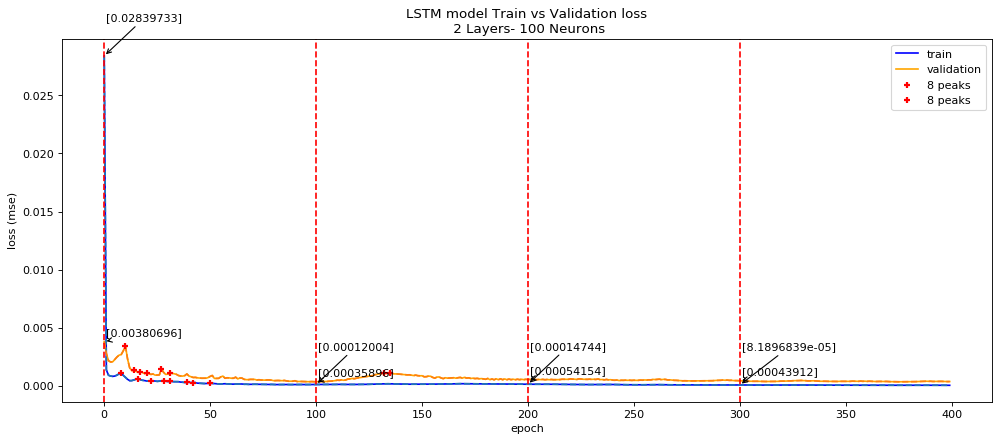

In [33]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
show_every = 100

vertical_lines = [x for x in range(epochs) if x % show_every == 0]

plt.plot(train, color='blue', label='train')
plt.plot(val, color='orange', label='validation')
plt.title(f'LSTM model Train vs Validation loss\n 2 Layers- {neurons} Neurons')
plt.ylabel('loss (mse)')
plt.xlabel('epoch')
plt.legend()

unflat = train.values.tolist()
unflat1 = val.values.tolist()
flatten = [ item for sublist in  unflat for item in sublist]
flatten1 = [ item for sublist in  unflat1 for item in sublist]
import peakutils
from peakutils.plot import plot as pplot

indexes = peakutils.indexes(flatten, thres=0.005, min_dist=1)
indexes1 = peakutils.indexes(flatten1, thres=0.2, min_dist=1)

pplot(train.index, train.values, indexes)
pplot(val.index, val.values, indexes1)
for xc in vertical_lines:
    plt.axvline(x=xc, color = 'r', linestyle = '--')
for i,j in zip(train.index, train.values):
    if i % show_every == 0:
        plt.annotate(str(j), xy = (i,j ), xytext=(i+1, j+.00300),arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
for i,j in zip(val.index, val.values):
    if i % show_every == 0:
        plt.annotate(str(j), xy = (i,j ), xytext=(i+1, j+.00050),arrowprops=dict(arrowstyle="->",connectionstyle="arc3"))
#plt.savefig('new_300_epochs.png')
print(indexes1)
plt.show()

R2 of train = 0.998
R2 of test = 0.982

RMSE of train = 52.493
RMSE of test = 188.506

MAE of train = 12.107
MAE of test = 211.459


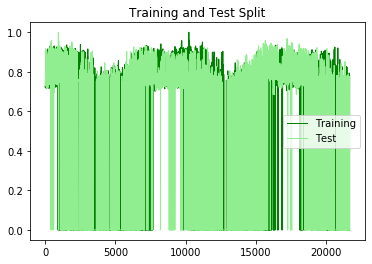

<Figure size 1296x144 with 0 Axes>

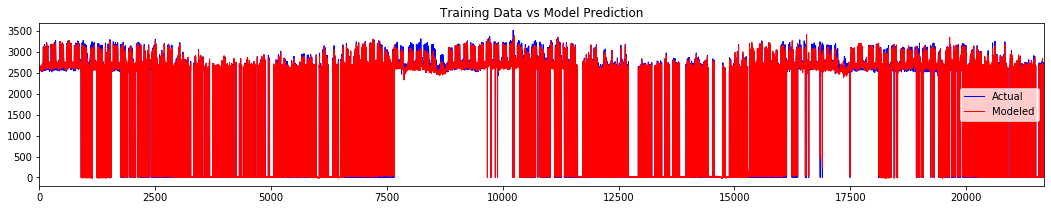

<Figure size 1296x144 with 0 Axes>

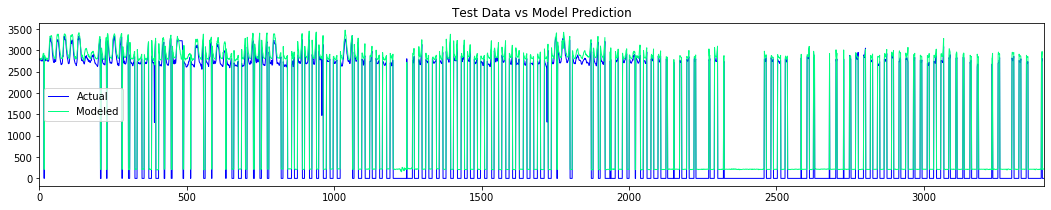

In [19]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import math
plt.plot(y_train, linewidth=1, color='green')
plt.plot(y_test, color='lightgreen', linewidth=1)
plt.title("Training and Test Split")
plt.legend(['Training','Test'])

pred_train = history.model.predict(X_train)
pred_train_inv = scaler_y.inverse_transform(pred_train.reshape(-1,1))
pred_test = history.model.predict(X1_test)
pred_test_inv = scaler_y.inverse_transform(pred_test.reshape(-1,1))
pred_test_inv = pred_test_inv+200
plt.figure(figsize=(18,2))
training_comparison = pd.DataFrame({"Actual":scaler_y.inverse_transform(y_train).reshape((-1,)),
                                   "Modeled":pred_train_inv.reshape((-1,))}, index=range(len(y_train)))
training_comparison.sort_index().plot(figsize=(18,3),
                         title="Training Data vs Model Prediction",
                         linewidth=1,
                         color=['blue','red'])
 
plt.figure(figsize=(18,2))
test_comparison = pd.DataFrame({"Actual":scaler_y.inverse_transform(y1_test).reshape((-1,)),
                                   "Modeled":pred_test_inv.reshape((-1,))}, index=range(len(y1_test)))
test_comparison.sort_index().plot(figsize=(18,3),
                     title="Test Data vs Model Prediction",
                     linewidth=1,
                     colormap='winter')

r2_train = r2_score(scaler_y.inverse_transform(y_train).reshape((-1,)), pred_train_inv.reshape(-1,1))
print(f"R2 of train = {round(r2_train,3)}")
r2_test = r2_score(scaler_y.inverse_transform(y1_test).reshape((-1,)), pred_test_inv.reshape(-1,1))
print(f"R2 of test = {round(r2_test,3)}")
print()
rmse_train = math.sqrt(mean_squared_error(scaler_y.inverse_transform(y_train).reshape((-1,)), pred_train_inv.reshape(-1,1)))
print(f"RMSE of train = {round(rmse_train,3)}")
rmse_test = math.sqrt(mean_squared_error(scaler_y.inverse_transform(y1_test).reshape((-1,)), pred_test_inv.reshape(-1,1)))
print(f"RMSE of test = {round(rmse_test,3)}")
print()
mae_train = np.median((pred_train_inv.reshape(-1,1) - scaler_y.inverse_transform(y_train).reshape((-1,))))
print(f"MAE of train = {round(mae_train,3)}")
mae_test = np.median((pred_test_inv.reshape(-1,1) - scaler_y.inverse_transform(y1_test).reshape((-1,))))
print(f"MAE of test = {round(mae_test,3)}")